In [22]:
# Import pandas 
import pandas as pd
pd.reset_option('display.max_columns')

# Groups of columns we want to use in our model
applicant_numeric=['annual_inc','dti','age_earliest_cr','loan_amnt', 'installment']
applicant_categorical=['application_type', 'emp_length', 'home_ownership', 'addr_state', 'term']
credit_numeric=['acc_now_delinq','acc_open_past_24mths','avg_cur_bal','bc_open_to_buy',
                'bc_util','delinq_2yrs','delinq_amnt','fico_range_high','fico_range_low',
                'last_fico_range_high','last_fico_range_low','open_acc','pub_rec','revol_util',
                'revol_bal','tot_coll_amt','tot_cur_bal','total_acc','total_rev_hi_lim',
                'num_accts_ever_120_pd','num_actv_bc_tl','num_actv_rev_tl','num_bc_sats',
                'num_bc_tl','num_il_tl', 'num_rev_tl_bal_gt_0','pct_tl_nvr_dlq',
                'percent_bc_gt_75','tot_hi_cred_lim','total_bal_ex_mort','total_bc_limit',
                'total_il_high_credit_limit','total_rev_hi_lim','all_util', 'loan_to_income',
                'installment_pct_inc','il_util_ex_mort','total_bal_il','total_cu_tl']
label = ['grade']

# Read in lending club data 
# ...skip the columns we're not going to use to preserve memory
lcdata = pd.read_csv("/tmp/lcdata/lc-2015-loans.csv", 
                     low_memory=False, 
                     usecols=applicant_numeric + applicant_categorical + credit_numeric + label)


#print(lcdata.describe())


Rows with null/NaN values: 129
Columns with null/NaN values:
Dropping bad rows...
Rows with null/NaN values: 0


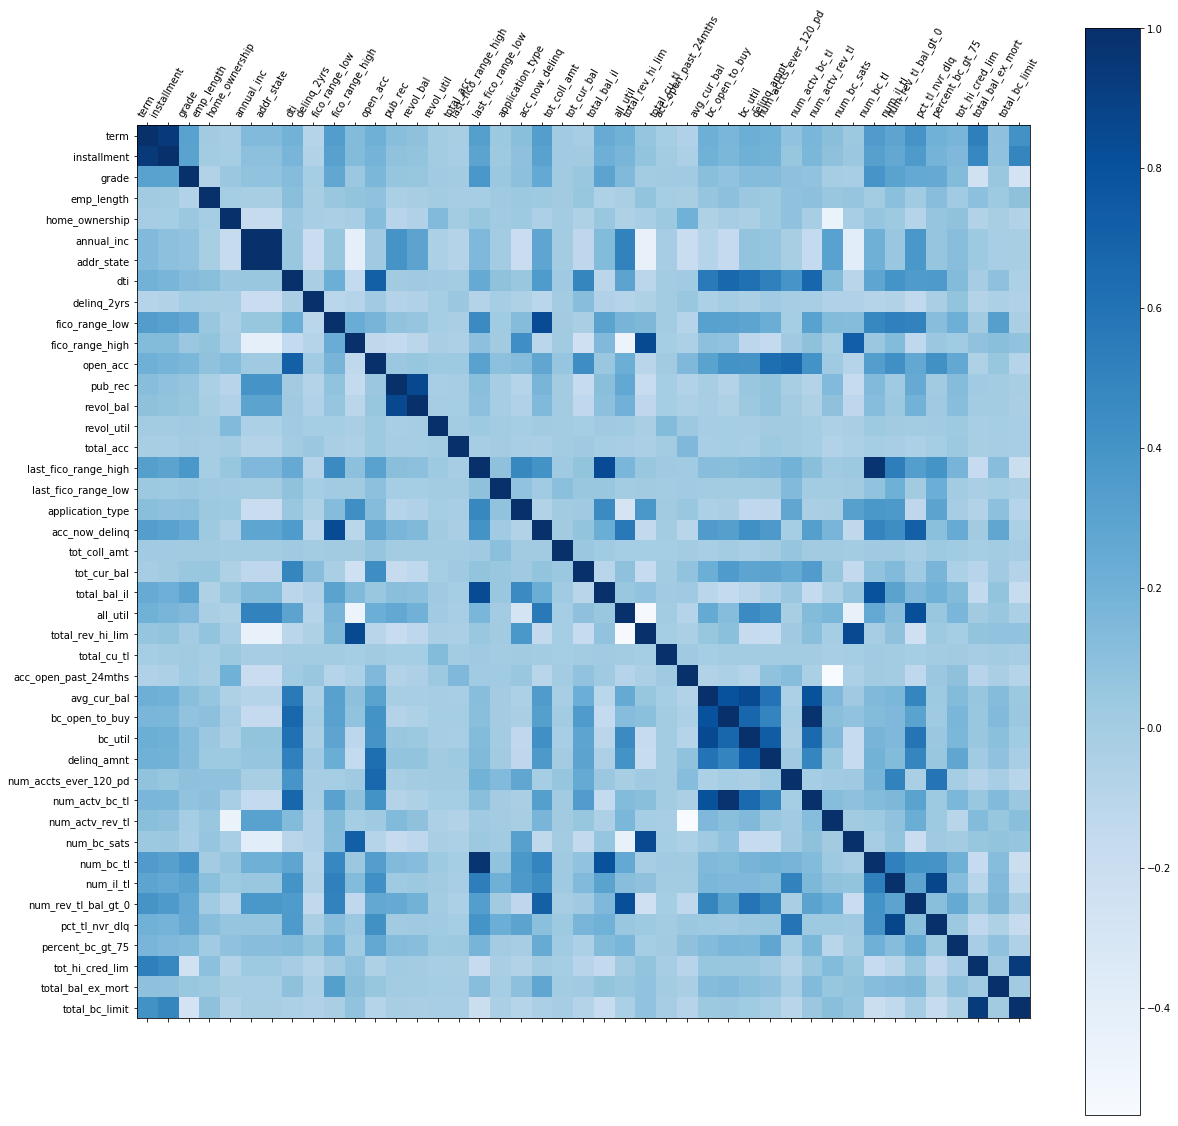

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

bad_rows = lcdata.isnull().T.any().T.sum()
print("Rows with null/NaN values: {}".format(bad_rows))
if bad_rows > 0:
    print("Columns with null/NaN values:")
    pd.isnull(lcdata).sum() > 0
    print ("Dropping bad rows...")
    lcdata.dropna(axis=0, how='any', inplace=True)
    print("Rows with null/NaN values: {}".format(lcdata.isnull().T.any().T.sum()))
    
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
cax = ax.matshow(lcdata.corr(), cmap=plt.cm.Blues)
fig.colorbar(cax)

ax.set_xticklabels(lcdata, rotation=60)
ax.set_yticklabels(lcdata)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [44]:
# Select a sample of the rows for processing locally (so it isn't painfully slow!)
data = lcdata.sample(60000)

# Print info on lending club data
# print(data.info())
# print(data.head())

In [45]:
# X is only the columns we want to use from the source data
#X=lcdata.loc[:, applicant_numeric + applicant_text + applicant_categorical + credit_numeric]

X=data.loc[:, applicant_numeric + applicant_categorical + credit_numeric]



def encode_categorical(x, categorical_cols):
    label_data = None
    cat_data = None
    for col in categorical_cols:
        # use get_dummies() to do one hot encoding of categorical column
        x = x.merge(pd.get_dummies(x[col]), left_index=True, right_index=True)
        
        # drop the original categorical column
        x.drop(col, axis=1, inplace=True)
        
    print(x.shape)
    return x

X = encode_categorical(X, applicant_categorical)

# Standardize numeric columns
for col in applicant_numeric + credit_numeric:
    X[col] = (X[col] - X[col].mean())/X[col].std()

print(X.sample())

(60000, 112)
        annual_inc      dti  age_earliest_cr  loan_amnt  installment  \
420636   -0.594184  0.13325         0.010086  -1.030976    -0.906504   

        acc_now_delinq  acc_open_past_24mths  avg_cur_bal  bc_open_to_buy  \
420636       -0.072114              0.733984    -0.350159       -0.432711   

         bc_util     ...      TX  UT  VA  VT  WA  WI  WV  WY   36 months  \
420636  0.207652     ...       0   0   0   0   0   0   0   0           1   

         60 months  
420636           0  

[1 rows x 112 columns]


In [46]:
# Specify the target labels and flatten the array 
y=pd.get_dummies(data.grade)
print(y.sample())

        A  B  C  D  E  F  G
393761  1  0  0  0  0  0  0


In [47]:
# Import `train_test_split` from `sklearn.model_selection`
from sklearn.model_selection import train_test_split

# Split the data up in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print(X_train.head())


        annual_inc       dti  age_earliest_cr  loan_amnt  installment  \
81223    -0.095649 -0.582906        -0.920129  -0.377172    -0.705937   
411176    0.344235 -0.527902         0.338736   0.323333    -0.288017   
41644    -0.608847 -1.790799        -1.237273  -1.544680    -1.509146   
348072   -0.635930  0.892308        -0.657281  -0.085295    -0.404615   
31410    -0.734947 -0.670913        -0.821966  -0.423872    -0.548030   

        acc_now_delinq  acc_open_past_24mths  avg_cur_bal  bc_open_to_buy  \
81223        -0.072114              1.987496    -0.649653        0.096435   
411176       -0.072114              1.047362     3.057598       -0.298896   
41644        -0.072114              1.674118    -0.663190       -0.550665   
348072       -0.072114             -0.832907     0.067366       -0.363955   
31410        -0.072114             -0.206151    -0.751246       -0.637501   

         bc_util     ...      TX  UT  VA  VT  WA  WI  WV  WY   36 months  \
81223  -0.033240     .

In [48]:
# Import `Sequential` from `keras.models`
from keras.models import Sequential

# Import `Dense` from `keras.layers`
from keras.layers import Dense, Dropout

from keras.constraints import maxnorm

print(y.shape[1])

def baseline_model():
    # create model
    model = Sequential()
    # input layer
    model.add(Dense(100, input_dim=X.shape[1], activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    
    # hidden layer
    model.add(Dense(100, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    
    # output layer
    model.add(Dense(y.shape[1], activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = baseline_model()
history = model.fit(X_train.as_matrix(), y_train.as_matrix(), validation_split=0.2, epochs=40, batch_size=32, verbose=2)

7
Train on 32160 samples, validate on 8040 samples
Epoch 1/40
1s - loss: 1.3490 - acc: 0.4238 - val_loss: 1.1721 - val_acc: 0.4851
Epoch 2/40
1s - loss: 1.1487 - acc: 0.4989 - val_loss: 0.9837 - val_acc: 0.5790
Epoch 3/40
1s - loss: 0.9767 - acc: 0.5701 - val_loss: 0.7927 - val_acc: 0.6591
Epoch 4/40
1s - loss: 0.8277 - acc: 0.6388 - val_loss: 0.6570 - val_acc: 0.7301
Epoch 5/40
1s - loss: 0.7198 - acc: 0.6855 - val_loss: 0.5660 - val_acc: 0.7658
Epoch 6/40
1s - loss: 0.6494 - acc: 0.7196 - val_loss: 0.5163 - val_acc: 0.7879
Epoch 7/40
1s - loss: 0.5911 - acc: 0.7462 - val_loss: 0.4618 - val_acc: 0.8173
Epoch 8/40
1s - loss: 0.5672 - acc: 0.7567 - val_loss: 0.4592 - val_acc: 0.8133
Epoch 9/40
1s - loss: 0.5342 - acc: 0.7693 - val_loss: 0.4506 - val_acc: 0.8131
Epoch 10/40
1s - loss: 0.5100 - acc: 0.7821 - val_loss: 0.4112 - val_acc: 0.8303
Epoch 11/40
1s - loss: 0.4956 - acc: 0.7864 - val_loss: 0.4068 - val_acc: 0.8354
Epoch 12/40
1s - loss: 0.4821 - acc: 0.7945 - val_loss: 0.3897 - va

dict_keys(['acc', 'val_loss', 'loss', 'val_acc'])


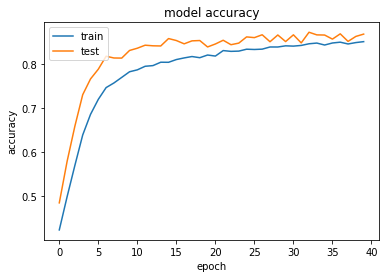

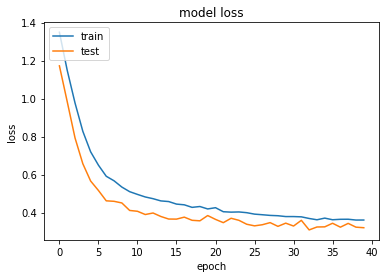

In [49]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [50]:
import numpy as np

y_pred = model.predict(X_test.as_matrix())

y_pred_classes = pd.DataFrame((y_pred.argmax(1)[:,None] == np.arange(y_pred.shape[1])), columns=y_test.columns,index=y_test.index)

score = model.evaluate(X_test.as_matrix(), y_test.as_matrix(), verbose=2)

print("Test Set Loss: {:.00%}, Accuracy: {:.00%}".format(score[0], score[1]))

Test Set Loss: 32%, Accuracy: 86%


0.864123883907


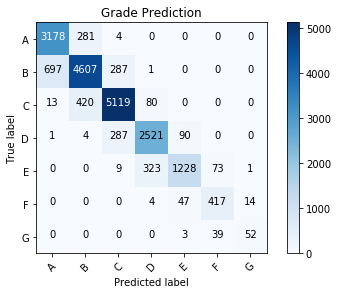

In [51]:
# Import the modules from `sklearn.metrics`
from sklearn.metrics import confusion_matrix, f1_score

# F1 score
# Use idxmax() to convert back from one-hot encoding
f1 = f1_score(y_test.idxmax(1), y_pred_classes.idxmax(1), average='weighted')
print(f1)

# Confusion matrix
cfn_matrix = confusion_matrix(y_test.idxmax(1), y_pred_classes.idxmax(1))

import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cfn_matrix, classes=y_test.columns,
                      title='Grade Prediction')
plt.show()